Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install keras-layer-normalization

  Preparing metadata (setup.py) ... done
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4668 sha256=deacafee1ab95875c08a15dfb423fbccc6e069c77be9609c97527c1122abe8c7
  Stored in directory: /root/.cache/pip/wheels/ed/3a/4b/21db23c0cc56c4b219616e181f258eb7c57d36cc5d056fae9a
Successfully built keras-layer-normalization


In [3]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#root_path = '/content/gdrive/My Drive/Course/Melanoma_Detection/ISIC'  #change dir to your project folder

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
root_path = '/kaggle/input/melanoma-isic/Skin cancer ISIC The International Skin Imaging Collaboration'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9
max_pool_size = (2, 2)
num_channels = 3

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#train_ds = ##todo

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
          data_dir_train,
          validation_split=0.2,
          subset="training",
          seed=123,
          image_size=(img_height, img_width),
          batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#val_ds = ##todo
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

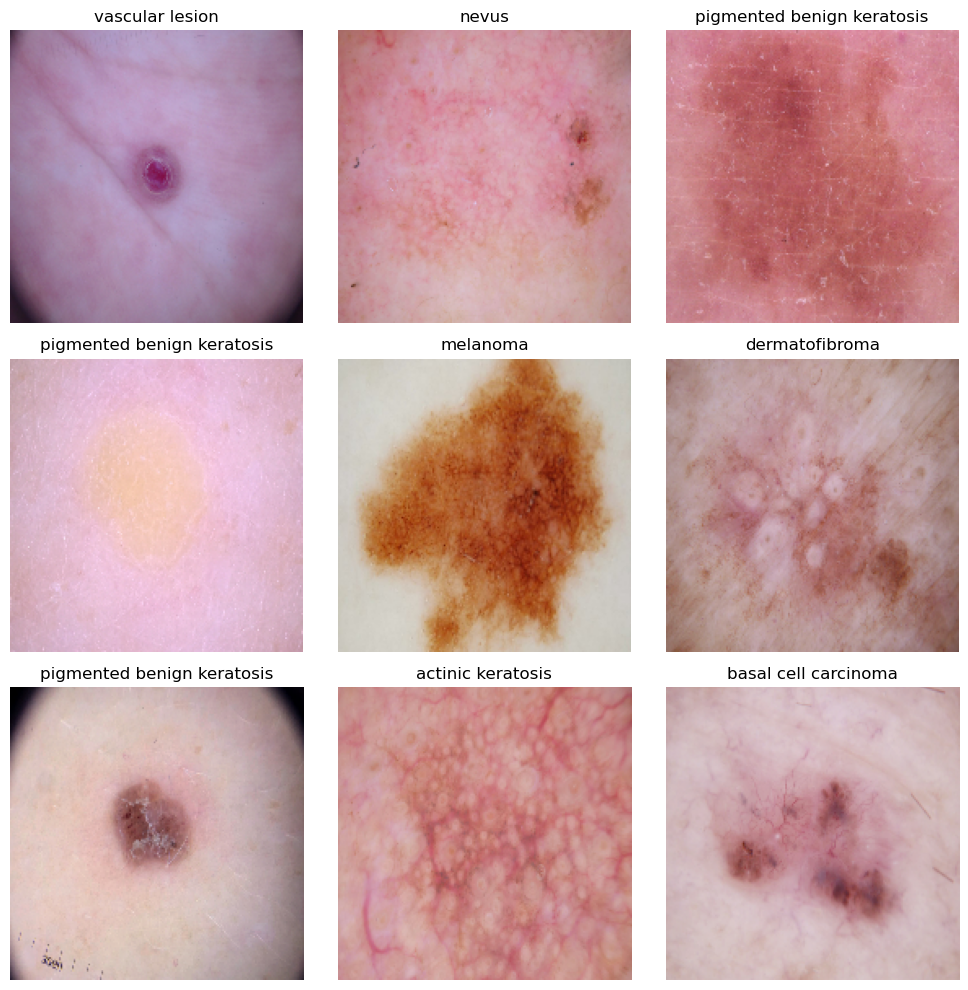

In [11]:

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 1. Basic Model

### a. Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### b. Compile the model
Choosing appropirate optimiser and loss function for model training

*Optimser* : The optimizer is responsible for updating the model's weights during training to minimize the loss function. Different optimizers have different update rules and may work better for different types of problems. The **Adam optimizer** is a popular choice because it combines the advantages of two other extensions of stochastic gradient descent (SGD), AdaGrad and RMSprop. It tends to work well for a wide range of deep learning tasks. An article https://iopscience.iop.org/article/10.1088/1757-899X/982/1/012005/pdf has published on this problem statement Adam seems to have worked well there.

*Loss Function* : The given problem is a multi-class classification problem where each sample can only belong to one class hence chosing **SparseCategoricalCrossentropy**.  If there is a multi-label classification problem (where each sample can belong to multiple classes), we might use BinaryCrossentropy. If we are dealing with a regression problem (predicting continuous values), we can use MeanSquaredError or other regression-specific loss functions.

*Metric* : For a multi-class classification problem, '**accuracy**' is a commonly used metric. However, we can include other metrics like 'precision', 'recall', or 'F1-score' based on the nature of the data and the specific requirements of the task. 

### c. Summarise the Model

### d. Train the Model

In [13]:
### Your code goes here
model_1 = keras.Sequential([  
    layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(32, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),    

    layers.Conv2D(128, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(512, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.40),

    layers.Dense(units=num_classes, activation='softmax')
])

### Todo, choose an appropirate optimiser and loss function

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_1.compile(optimizer= opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model_1.summary()

epochs = 20
history_1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       3

### Visualizing training results

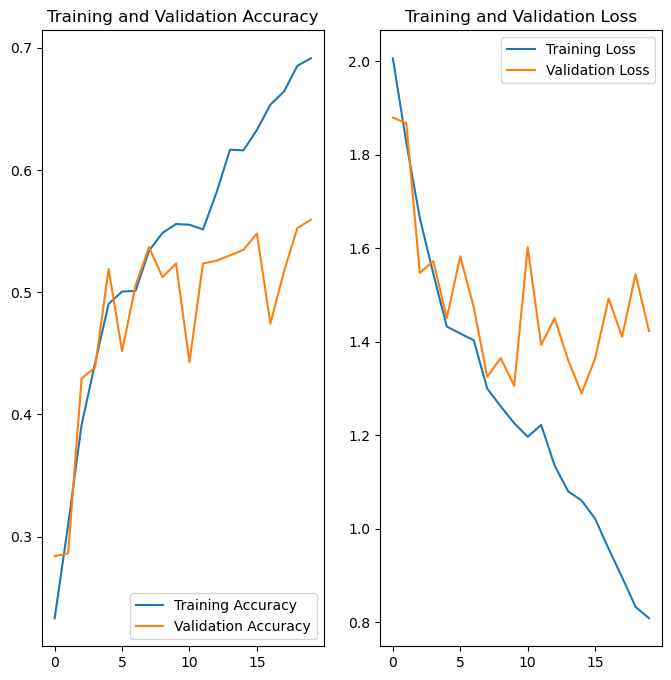

In [16]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Model Observation

Model is underfitting since the accuracy on training data is only around 69% and validation is around 55% which indicates overfitting as well as the difference is greater than 5%. 

To address these problems, we will be augmenting the training data with transformations like rotations and flips can help improve data quality in the next model.Other techniques that can be applied are  increasing model capacity, train longer, adjust learning rate and reduce regularization.

***Data augmentation*** is a technique commonly used in machine learning, especially for image datasets, to artificially increase the diversity of the training data by applying various transformations to the existing images. The goal of data augmentation is to create new variations of the images that are still representative of the original data but introduce small changes such as rotations, flips, zooming, and color adjustments. This helps the model generalize better to unseen data and reduces overfitting, especially when dealing with limited training data. I've opted for Random horizontal and vertical flip,random rotation, random soom and random contrast for this exercise.

In [19]:
# Apply augmentation strategy to the image
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

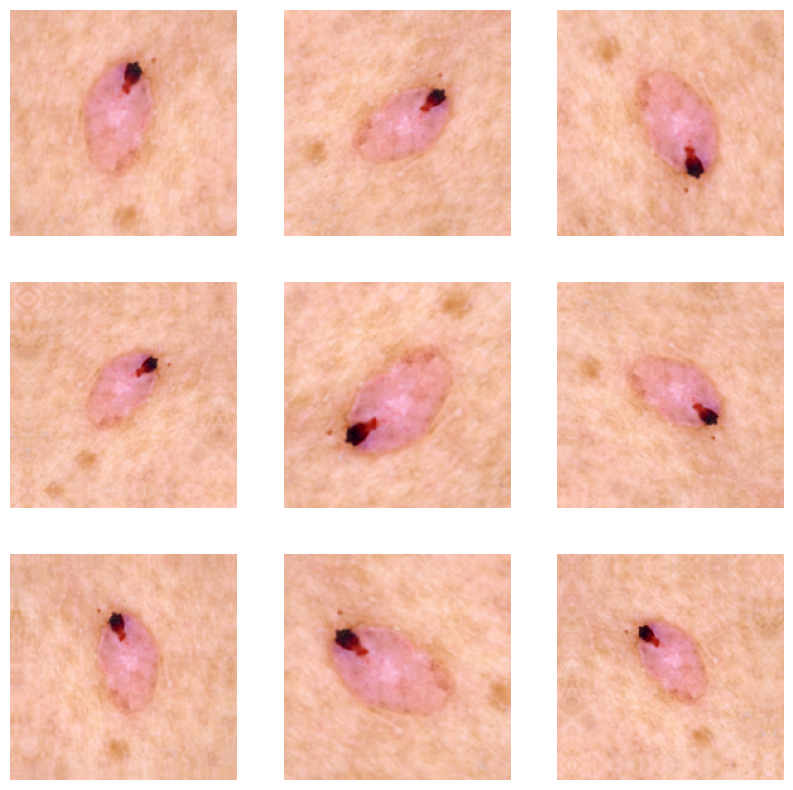

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### 2. Model with data augmentation 


In [21]:
# CNN Model with data augmentation
model_2 = tf.keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(32, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),    

    layers.Conv2D(128, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(512, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.4),

    layers.Dense(units=num_classes, activation='softmax')
])


## Your code goes here

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Your code goes here, note: train your model for 20 epochs
epochs = 20
history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 49ms/step - loss: 2.0124 - accuracy: 0.2321 - val_loss: 1.9046 - val_accuracy: 0.2841
Epoch 2/20
56/56 [==============================] - 3s 48ms/step - loss: 1.8416 - accuracy: 0.3041 - val_loss: 1.7044 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 2s 44ms/step - loss: 1.6715 - accuracy: 0.3828 - val_loss: 1.5911 - val_accuracy: 0.4362
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.5870 - accuracy: 0.4286 - val_loss: 1.5389 - val_accuracy: 0.4497
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 1.5899 - accuracy: 0.4208 - val_loss: 1.4714 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 2s 44ms/step - loss: 1.4772 - accuracy: 0.4699 - val_loss: 1.4237 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.3916 - accuracy: 0.4939 - val_loss: 1.6211 - val_accuracy: 0.4295
Epoch 8/20
56

### Visualizing the results

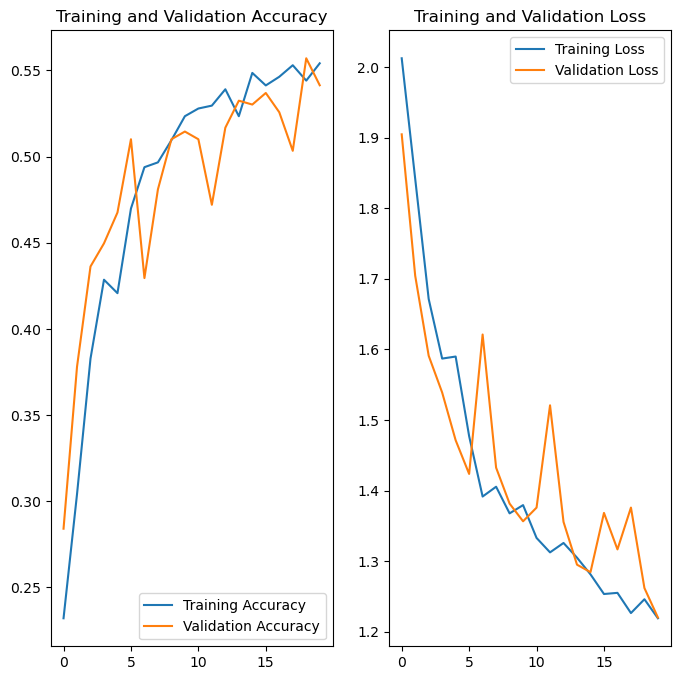

In [24]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Observation 

Training data accuracy is 55% and test data accuracy is 54%. although there is no overfitting the model is performing poorly. We will check the distribution of the classes to decide if there is any imbalance in the data.

By addressing class imbalance, we can improve the CNN model's ability to recognize and classify all classes effectively, leading to better overall performance and a more fair and unbiased classifier.


#### Find the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

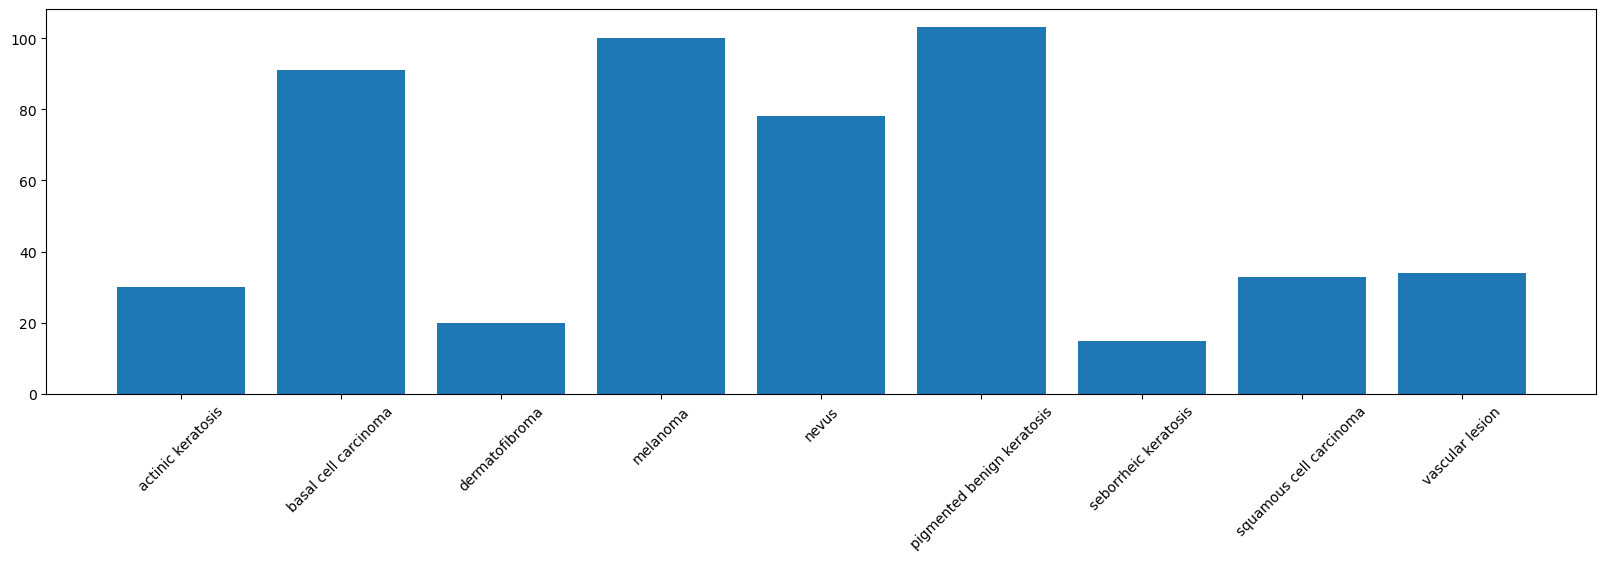

In [15]:
## Your code goes here.
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.xticks(rotation=45)
plt.show()

In [10]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
Seborrheic keratosis has the least number of samples

#### - Which classes dominate the data in terms proportionate number of samples?
The classes with the most samples are: 
- pigmented benign keratosis 
- melanoma 
- basal cell carcinoma 
- nevus 

Clearly the classes "pigmented benign keratosis" and "melanoma" dominate the data.

#### Handling class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
path_to_training_dataset = "/kaggle/input/melanoma-isic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/data/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 1000 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x798B8A368430>: 100%|██████████| 500/500 [00:12<00:00, 39.42 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/data/basal cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x798B7C071DE0>: 100%|██████████| 500/500 [00:12<00:00, 41.08 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/data/dermatofibroma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x798B640D0580>: 100%|██████████| 500/500 [00:13<00:00, 38.10 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/data/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x798B642937F0>: 100%|██████████| 500/500 [01:07<00:00,  7.44 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/data/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x798C184C3910>: 100%|██████████| 500/500 [01:14<00:00,  6.74 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/data/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x798B6421EF80>: 100%|██████████| 500/500 [00:13<00:00, 36.91 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/data/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x798B8A36BEE0>: 100%|██████████| 500/500 [00:30<00:00, 16.42 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/data/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x798C18323190>: 100%|██████████| 500/500 [00:12<00:00, 39.73 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/data/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x798BA823EDD0>: 100%|██████████| 500/500 [00:13<00:00, 37.14 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
output_dir = pathlib.Path('/kaggle/working/data/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

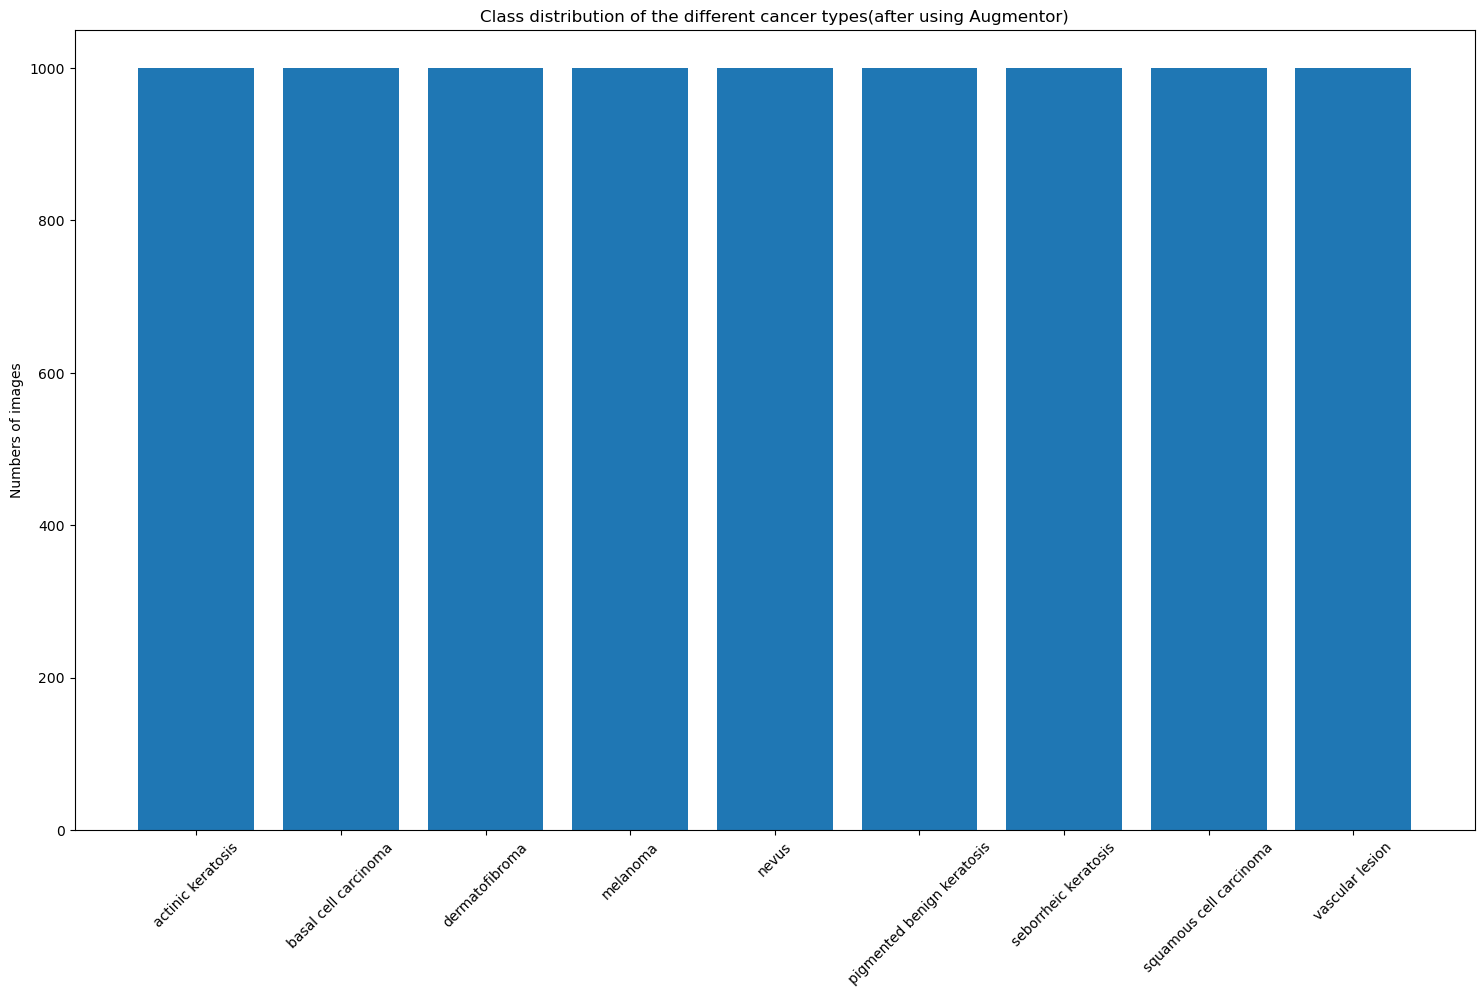

In [39]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(output_dir.glob(class_names[i]+'/*.jpg'))) + len(list(output_dir.glob(class_names[i]+'/output/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types(after using Augmentor)')
plt.xticks(rotation=45)
plt.show()
     

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### 3. Model with with data augmentation and augmentor to handle class imbalance

#### **Todo:** Create a training dataset

In [41]:
balanced_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


#### **Todo:** Create a validation dataset

In [42]:
balanced_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [43]:
# CNN Model with data augmentation and batch normalization
model_3 = tf.keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, 2, padding="same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 2, padding="same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 2, padding="same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 2, padding="same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(512, 2, padding="same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(1024),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(units=num_classes, activation='softmax')
])

## Your code goes here

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model_3.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


epochs = 30
history = model_3.fit(
  balanced_train_ds,
  validation_data=balanced_val_ds,
  epochs=epochs
)

Epoch 1/30
225/225 [==============================] - 33s 117ms/step - loss: 1.7047 - accuracy: 0.4107 - val_loss: 2.6347 - val_accuracy: 0.1467
Epoch 2/30
225/225 [==============================] - 27s 116ms/step - loss: 1.3600 - accuracy: 0.4985 - val_loss: 1.6345 - val_accuracy: 0.3644
Epoch 3/30
225/225 [==============================] - 27s 117ms/step - loss: 1.2421 - accuracy: 0.5421 - val_loss: 1.1748 - val_accuracy: 0.5406
Epoch 4/30
225/225 [==============================] - 27s 117ms/step - loss: 1.1334 - accuracy: 0.5786 - val_loss: 1.5226 - val_accuracy: 0.4806
Epoch 5/30
225/225 [==============================] - 26s 115ms/step - loss: 1.0603 - accuracy: 0.5985 - val_loss: 1.1034 - val_accuracy: 0.6006
Epoch 6/30
225/225 [==============================] - 27s 117ms/step - loss: 0.9801 - accuracy: 0.6307 - val_loss: 1.3944 - val_accuracy: 0.5200
Epoch 7/30
225/225 [==============================] - 27s 118ms/step - loss: 0.9304 - accuracy: 0.6435 - val_loss: 0.8130 - val_ac

In [45]:
 #Evaluate the model on the validation dataset
train_loss, train_accuracy = model_3.evaluate(balanced_train_ds)
val_loss, val_accuracy = model_3.evaluate(balanced_val_ds)


57/57 [==============================] - 5s 72ms/step - loss: 0.4511 - accuracy: 0.8306


In [46]:
# Print the validation accuracy
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Training Accuracy: 0.8606944680213928
Validation Accuracy: 0.8305555582046509


#### **Todo:**  Visualize the model results

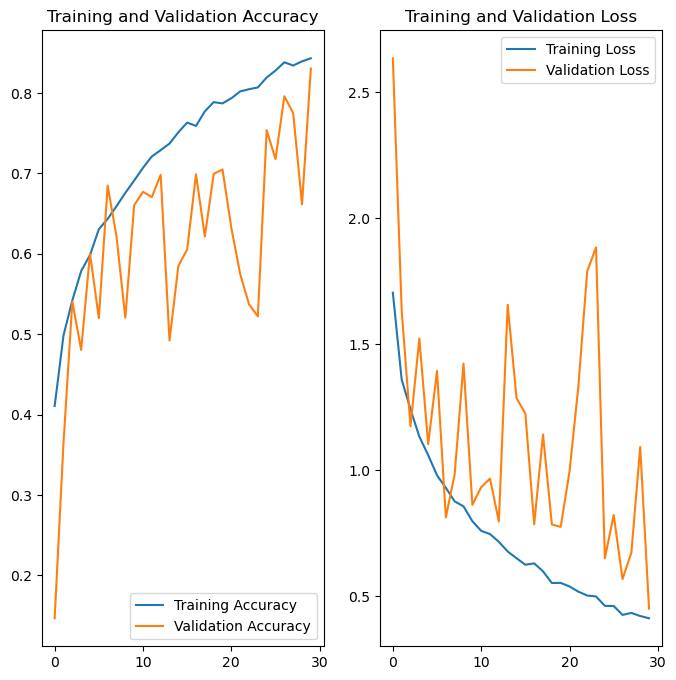

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Model Observation**

The results with dataset augmentation have shown significant improvement over previous models, with training accuracy of 0.86 at 30 epochs, and validation accuracy at 0.83. But, there seems to be large fluctuations in the validation loss and this  can indicate that the CNN model is struggling to converge and find a stable solution. Such fluctuations can hinder the model's ability to generalize well to unseen data. Few steps to address the issues are  -  adjusting learning rate, consider larger batch size, consider early stopping, etc.